In [45]:
# 2FFOH pyrolysis 2045_p

In [1]:
import cantera as ct
import numpy as np
import pandas as pd
import os
%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

from IPython.display import display, HTML

import scipy
import scipy.optimize

print(f"Running Cantera Version: {ct.__version__}")

Running Cantera Version: 2.6.0


In [2]:
# Import plotting modules and define plotting preference

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 120

# Get the best of both ggplot and seaborn
plt.style.use("ggplot")
plt.style.use("seaborn-deep")
plt.rcParams["figure.autolayout"] = True

In [6]:
# Inlet Temperature in Kelvin and Inlet Pressure in Pascals
T_range = [T for T in range (900,1400,100)]  #Kelvin
#T_range = [1000]
pressure = 0.04*1e5  # constant pressure, ]Pa[]

# Define the gas-mixutre and kinetics
gas = ct.Solution("output.yaml")

composition = {"furfuryl(1)": 0.01, "He": 0.99}

# Define the components and concentrations. The names must match to thoes in your model:
# phi = 5.5/21
# composition = {"furfuryl(1)": 1, "O2(2)": 5.5/phi, "N2": 5.5*3.76/phi}

In [7]:
#PFR, paper: https://www.sciencedirect.com/science/article/pii/S1540748920305757?via%3Dihub

length = 0.22  # *approximate* PFR length, m
internal_diameter = 0.007 #m
area = np.pi*(1/4)*internal_diameter**2  # cross-sectional area, m^2
inlet_flow_rate = 0.001/60  #in my case it's 1 L/minute = 0.001 m^3/60 sec
u_0 = inlet_flow_rate/area  # inflow velocity, m/s 

In [8]:
species_list = gas.species()
#define your observables:
observables = ['furfuryl(1)']

In [51]:
# Set the value of the perturbation
dk = 1e-2

In [ ]:
# Resolution: The PFR will be simulated by 'n_steps' time steps or by a chain of 'n_steps' stirred reactors.
n_steps = 1000

# time in the end of the PFR!
t_total = length / u_0
print("total time is:",t_total)
dt = t_total / n_steps
# define time, space, and other information vectors
t1 = (np.arange(n_steps) + 1) * dt

# import the gas model and set the initial conditions
gas1 = gas
species = gas1.species_names

def solve_pfr_in_outlet (T, t1, t_total):
    gas1.TPX = T, pressure, composition
    mass_flow_rate1 = u_0 * gas1.density * area
    # Initialize reactor and reactor network
    r1 = ct.IdealGasConstPressureReactor(gas1)
    sim1 = ct.ReactorNet([r1])
    z1 = np.zeros_like(t1)
    u1 = np.zeros_like(t1)
    states1 = ct.SolutionArray(r1.thermo)
    for n1, t_i in enumerate(t1):
        # perform time integration
        sim1.advance(t_i)
        # compute velocity and transform into space
        u1[n1] = mass_flow_rate1 / area / r1.thermo.density
        z1[n1] = z1[n1 - 1] + u1[n1] * dt
        states1.append(r1.thermo.state)

for species in observables:
    sensitivities = pd.DataFrame(index=gas1.reaction_equations(), columns=T_range)
    sensitivities.to_csv(species+'_sa_results.csv')
    for T in T_range:
        solve_pfr_in_outlet(T, t1, t_total)
        baseline_concentrations = gas1.mole_fraction_dict()

        for m in range(gas1.n_reactions): #n_reactions gives the number of reaction in the mechanism
            gas1.TP = T, pressure
            gas1.set_multiplier(1.0)  # Reset multipliers

            # Perturb the rate coefficient slightly
            k_i0 = gas1.forward_rate_constants[m]
            gas1.set_multiplier(1 + dk, m)
            solve_pfr_in_outlet(T, t1, t_total)
            sensitivity = (gas1.mole_fraction_dict()[species] - baseline_concentrations[species]) * (k_i0 / ((gas1.forward_rate_constants[m] - k_i0) * baseline_concentrations[species]))
            # Store sensitivity in the DataFrame
            sensitivities.at[ gas1.reaction_equation(m), T] = sensitivity
            # Save intermediate results to CSV file in each iteration
            sensitivities.to_csv(species+'_sa_results.csv')
        #sensitivities.to_csv(species+'_sa_results.csv', mode='a', index_label=T, header=False)
    sensitivities.to_csv(species+'_sa_results_final.csv')        
gas1.set_multiplier(1.0)

In [53]:
# sensitivities.info()

In [54]:
# reaction_rates = gas.net_rates_of_progress  # array of reaction rates

# # Print the reaction rates
# for i, reaction in enumerate(gas.reactions()):
#     rate = reaction_rates[i]
#     print(f"Reaction {i + 1}: {reaction.equation} - Rate: {rate}")

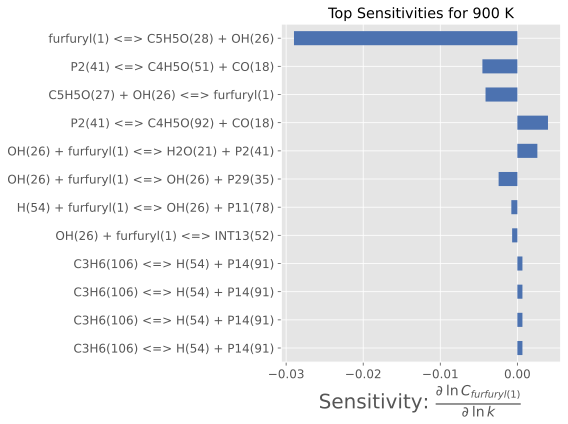

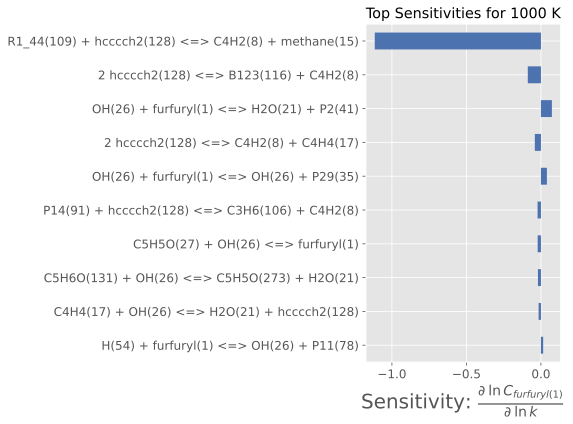

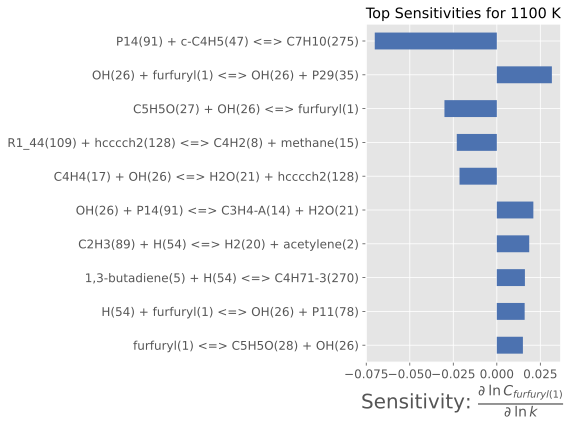

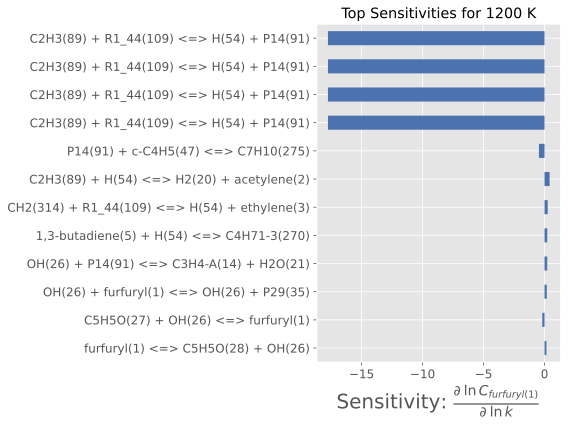

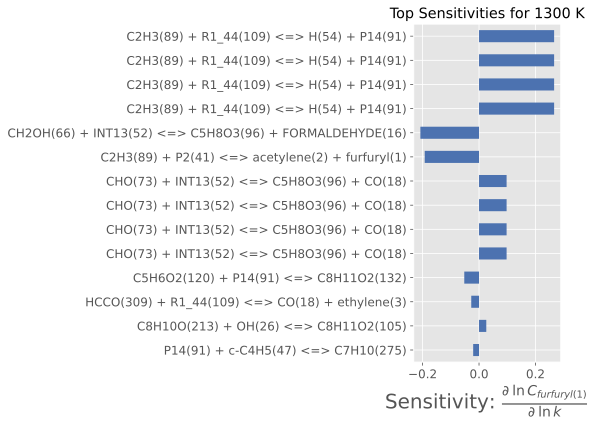

In [35]:
top_n = 10  # Number of top values to consider
for species in observables:
    file_name = species + '_sa_results_final.csv'
    if os.path.exists(file_name):
        sensitivities = pd.read_csv(file_name, index_col=0)
        temperatures = sensitivities.columns  # column indices
        for T in temperatures:
            sensitivities_T = sensitivities.loc[:, T]
            
            # Sort absolute values and select top 10
            top_sensitivities = sensitivities_T.abs().nlargest(top_n)
            
            # Get the rows' indices of the top sensitivities
            reactions_top = top_sensitivities.index
            
            # Plot the top sensitivities
            sensitivities_subset = sensitivities.loc[reactions_top, T]
            sensitivities_subset.plot.barh(
                title="Top Sensitivities for " + str(T) + " K",
                legend=None)
            plt.gca().invert_yaxis()
            plt.rcParams.update({"axes.labelsize": 20})
            plt.xlabel(f"Sensitivity: $\\frac{{\\partial\\:\\ln{{C_{{{species}}}}}}}{{\\partial\\:\\ln{{k}}}}$")
            plt.savefig(species + '_' + str(T) + 'K' + '_sa_top10', dpi=300)
            plt.show()